# Embeddings de caracter

Esse trabalho busca desenvolver um método para criação de embedding de caracter usando 3 textos de Fernando Pessoa.
A motivação para esse trabalho é que ele será utilizado para criação de outros modelos como por exemplo atribuição autoral. Foram considerados métodos Word2vec e fastText mas devido ao desempenho em tempo de máquina serem altos, decidiu-se criar esse método.

Será proposto 2 método e testado diferentes pesos. O primeiro método é o modelo de *linguagem puro* no qual uma sequência de caracteres é utilizada  para prever o caracter seguinte.  O segundo modelo é baseado em *skip-gram* onde os n vizinhos anteriores e os n posteriores são usados para prever o caracter do centro.

In [1]:
%matplotlib inline
#python basic libs
from __future__ import print_function

import os;
from time import time;
import string;

import re;
import glob;
import zipfile;
import json;
import codecs;
from collections import defaultdict, Counter;


#data analysis libs
import random;
import numpy as np;
import pandas as pd;
import seaborn as sn;
import matplotlib.pyplot as plt;


#machine learning libs
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.preprocessing import normalize, MaxAbsScaler, minmax_scale, LabelBinarizer, LabelEncoder;
from sklearn.preprocessing import robust_scale;
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity;
from scipy.spatial.distance import cosine;

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.base import BaseEstimator, ClassifierMixin

#classifiers
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.pipeline import Pipeline

#model valuation
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score;

## Leitura dos dados 

Os dados foram carrecados de arquivos-texto, foi removido acentuação, nova linha e espaços duplos.

In [2]:
import unicodedata
def strip_accents(s):
    normalized = unicodedata.normalize('NFKD', unicode(s))
    if normalized == s:
        return s
    else:
        return ''.join([c for c in normalized if not unicodedata.combining(c)])

def readTexts():
    s = '/Users/joseeleandrocustodio/Downloads/testauthoshipattribution';
    docs = {};
    for name in os.listdir(s):
        with codecs.open(os.path.join(s,name),'r') as ff:
            docs[name] = ff.read();
            docs[name] = strip_accents(docs[name].decode(encoding='utf-8', errors='ignore'))
            print(docs[name][0:5])
            #docs[name] = docs[name].encode('utf8');
            #docs[name]=filter(lambda x: x in string.printable, docs[name])
            docs[name]=re.sub(r'\r|\t|\n',' ',docs[name]);
            docs[name]=re.sub(r'[ \t]{2,}',' ',docs[name]);
    return docs;
        

##  criação do dicionário de caracteres válidos

Foi removido caracteres que tiverem menos que 10 ocorrências.

In [3]:
docs = readTexts();
authors, docs = docs.keys(), docs.values();
cnt = Counter((list(' '.join(docs))));
lowFrequency = ''.join([c for c in cnt if  cnt[c]<10])
for i in range(len(docs)):
    docs[i] = re.sub('['+lowFrequency+']','',docs[i])

Poema
Poema
O Gua


# Descritive analysis

Aplicando a teoria de Zipf para entender a distribição dos caracteres

In [4]:
cnt = Counter((list(' '.join(docs))))

In [5]:
print(re.sub(r'\t|\n','',docs[0])[0:500])

Poemas de Alvaro de Campos Alvaro de Campos (heteronimo de Fernando Pessoa) Fonte: http://www.cfh.ufsc.br/magno/ Poemas: • Adiamento • Lisboa Revisited () • La-Bas, Je ne sais ou • Vilegiatura • Clearl Non-Campos! • Vai pelo cais fora um bulicio de chegada proxima • Cruzou por mim, veio ter comigo, numa rua da baixa • Comeco a conhecer-me. Nao existo. • O ter deveres, que prolixa coisa! • Que lindos olhos de azul inocente os do pequenito do agiota • O descalabro a ocio e estrelas • Ora, ate que 


In [55]:
df = pd.DataFrame({'char':cnt.keys(),'values':cnt.values()}).sort_values('values',ascending=False)
df['n'] = np.arange(len(cnt))+1;
df['zipf'] = 1.0/df['n'];
df['prob'] = df['values']/df['values'].sum();
df['invTF'] = np.log(df['values'].sum()/df['values'])+1;
df.head(20)#.sort_values('values',ascending=False)

,char,values,n,zipf,prob,invTF
2,,31939,1,1.000000,0.184405,2.690619
40,e,17428,2,0.500000,0.100624,3.296369
37,a,17138,3,0.333333,0.098949,3.313149
49,o,15258,4,0.250000,0.088095,3.429343
53,s,11622,5,0.200000,0.067102,3.701547
54,r,8264,6,0.166667,0.047714,4.042538
44,i,7278,7,0.142857,0.042021,4.169591
47,m,6749,8,0.125000,0.038967,4.245053
50,n,6554,9,0.111111,0.037841,4.274371
55,u,6438,10,0.100000,0.037171,4.292229


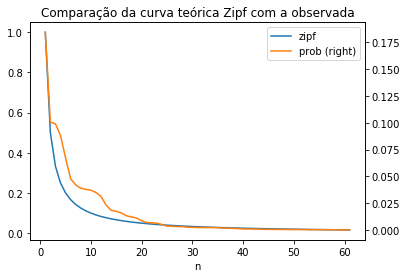

In [58]:
df.plot(x='n',y=['zipf', 'prob'], secondary_y=['prob'], title=u"Comparação da curva teórica Zipf com a observada");

AttributeError: 'module' object has no attribute 'plt'

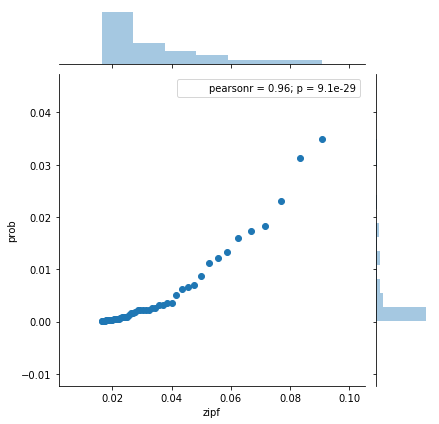

In [65]:
sn.jointplot(x='zipf',y='prob',data=df[df.zipf <  0.1]);
sn.plt.title(u"Análise da correlação entre Zipf e probabilidade");

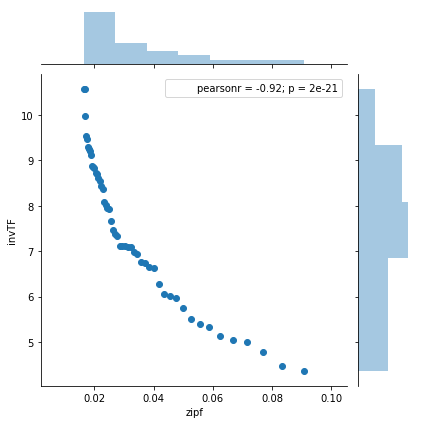

In [9]:
sn.jointplot(x='zipf',y='invTF',data=df[df.zipf <  0.1]);

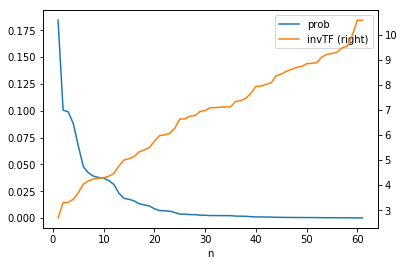

In [10]:
df.plot(x='n',y=['prob', 'invTF'], secondary_y=['invTF']);

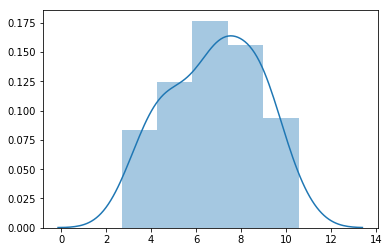

In [11]:
sn.distplot(df.invTF.values)

### Defining the vocabulary to be used and the caracter weight

In [12]:
vocabulary = {c:i for i,c in enumerate(cnt)}

In [13]:
print(''.join(vocabulary))

—! •')(-,/.r;:?ACBEDGFIHJMLONQPS"UTVXacbedgfihjmlonqpsRutwvxz


In [14]:
invVocabulary= dict(zip(vocabulary.values(), vocabulary.keys()))

In [15]:
vocabularyInvTF = dict(zip(df.char, df.invTF))

In [16]:
print(''.join(sorted(vocabulary)))

 !"'(),-./:;?ABCDEFGHIJLMNOPQRSTUVXabcdefghijlmnopqrstuvwxz—•


## Utility Methods

In [17]:
def plotMatrix(matrix,labels):
    fig, ax = plt.subplots(figsize=(13,13))
    ax.matshow(matrix, cmap=plt.cm.RdYlBu_r)
    plt.xticks(range(len(labels)),labels);
    plt.yticks(range(len(labels)),labels);
    plt.show()    

In [18]:
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.metrics.pairwise import pairwise_distances;

def plotDistanceMatrix(originalMatrix,labels, n_clusters=(10,10), metric='cosine' ):
    data = 1-pairwise_distances(originalMatrix, metric=metric);

    model = SpectralBiclustering(n_clusters=n_clusters, method='log',random_state=0)
    model.fit(data,clf.classes_)

    fit_data = data[np.argsort(model.row_labels_)]
    fit_data = fit_data[:, np.argsort(model.column_labels_)]
    plotMatrix(fit_data,labels[np.argsort(model.column_labels_)])

In [19]:
def plotDistanceMatrixCluster(originalMatrix,labels, n_clusters=10, metric='cosine' ):
    #c = AgglomerativeClustering(n_clusters=n_clusters, affinity=metric, linkage='complete')
    c= KMeans(n_clusters=n_clusters,init='k-means++')
    data = 1-pairwise_distances(clf.coef_, metric=metric);
    index = np.argsort(c.fit_predict(data))
    #if the data is normalized with norm='l1' then euclidian = 2(1-cosine_sim)
    fit_data = data[index]
    fit_data = fit_data[:, index]
    plotMatrix(fit_data,labels[index])

In [20]:
def plotTSNE(data,labels, figsize=(10, 10), norm='l2',metric='euclidean'):
    tsne_model = TSNE(metric=metric,
        perplexity=40,
        n_components=2,
        init='pca',
        n_iter=2500,
        random_state=23)
    new_values = tsne_model.fit_transform(normalize(data,norm=norm))
    plt.figure(figsize=(10, 10)) 
    for i,v in enumerate(new_values):
        plt.scatter(v[0],v[1])
        plt.annotate(labels[i], xy=(v[0], v[1]),xytext=(5, 4),
                     textcoords='offset points',ha='right',va='bottom',size=15)

# Modelo 1 - Language model 

In [21]:
def lm1_transform(doc,vocab, ngramas, verbose=False):
    arr = [doc[i:i+ngramas+1] for i in range(len(doc)-(ngramas))];
    
    values = np.zeros((len(arr), len(vocab)));
    keys = [];
    
    for i,d in enumerate(arr):
        keys.append(d[ngramas]);
        v = d[:-1];
        if verbose: print (d, '==>',v,',',d[ngramas])
        for j,vv in enumerate(v):
            values[i,vocab[vv]]+=(j+1.0)/ngramas;
    
    return values, keys;

In [22]:
x, y=lm1_transform('Language Model', vocabulary,3,verbose=True);
for i,v in enumerate(x[0]):
    if v >0:
        print(invVocabulary[i],'=',v)

Lang ==> Lan , g
angu ==> ang , u
ngua ==> ngu , a
guag ==> gua , g
uage ==> uag , e
age  ==> age ,  
ge M ==> ge  , M
e Mo ==> e M , o
 Mod ==>  Mo , d
Mode ==> Mod , e
odel ==> ode , l
L = 0.3333333333333333
a = 0.6666666666666666
n = 1.0


In [23]:
result = [];
for i in [1,2,3,5,7]:
    print('\nneighborhood:',i)
    acc=[];
    clf = LogisticRegression(random_state=42, C=10000,multi_class='multinomial',solver='lbfgs');
    for d in docs:
        X, Y = lm1_transform(d, vocabulary,i)
        X = normalize(X,axis=1, norm='l2');
        clf.fit(X,Y);
        accuracy =clf.score(X,Y);
        acc.append(accuracy);
    result.append({"i":i,'v0':acc[0],'v1':acc[1],'v2':acc[2], 'clf':clf})


neighborhood: 1

neighborhood: 2

neighborhood: 3

neighborhood: 5

neighborhood: 7


In [24]:
pd.DataFrame(result) #.plot(x='i', y=['v0','v1','v2'])

,clf,i,v0,v1,v2
0,"LogisticRegression(C=10000, class_weight=None,...",1,0.288941,0.311569,0.304253
1,"LogisticRegression(C=10000, class_weight=None,...",2,0.330651,0.362157,0.331138
2,"LogisticRegression(C=10000, class_weight=None,...",3,0.328408,0.357440,0.324185
3,"LogisticRegression(C=10000, class_weight=None,...",5,0.312942,0.349973,0.317573
4,"LogisticRegression(C=10000, class_weight=None,...",7,0.299995,0.336527,0.307093


In [25]:
clfM1 = LogisticRegression(random_state=42, C=10000,multi_class='multinomial',solver='lbfgs');
X, Y = lm1_transform(' '.join(docs), vocabulary,2)
X = normalize(X,axis=1, norm='l2');
clfM1.fit(X,Y);
accuracy =clfM1.score(X,Y);
print (accuracy)

0.3378330003810668


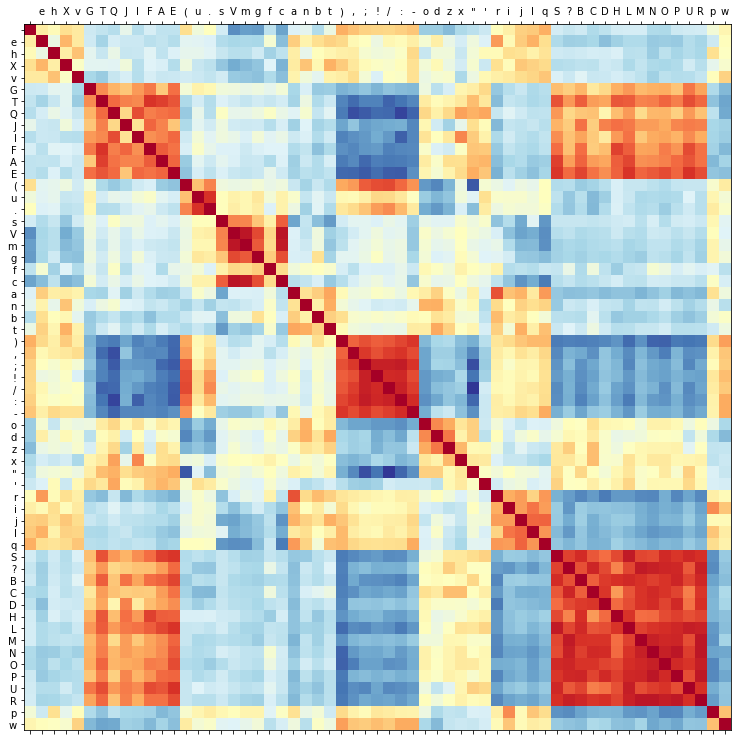

In [26]:
plotDistanceMatrixCluster(clfM1.coef_,clfM1.classes_,n_clusters=10)

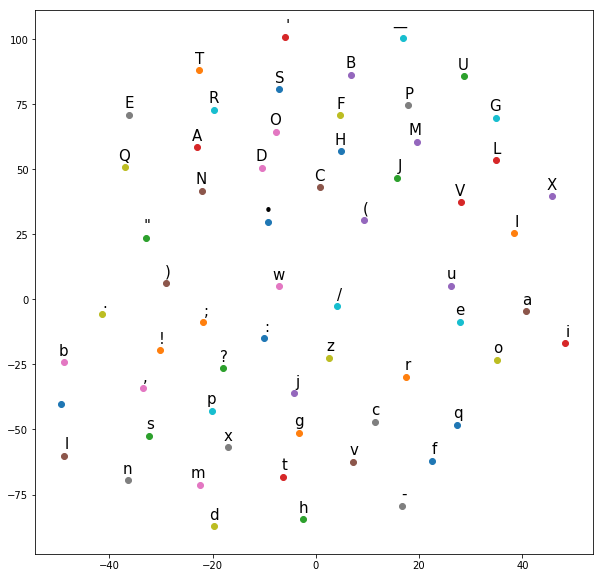

In [27]:
plotTSNE(clfM1.coef_,clfM1.classes_, metric='cosine')

<br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/>
# modelo 2 - Language Model with zipfs probability weight

In [28]:
def lm2_transform(doc,vocab, ngramas, verbose=False):
    arr = [doc[i:i+ngramas+1] for i in range(len(doc)-(ngramas))];
    
    values = np.zeros((len(arr), len(vocab)));
    keys = [];
    
    for i,d in enumerate(arr):
        keys.append(d[ngramas]);
        v = d[:-1];
        if verbose: print (d, '==>',v,',',d[ngramas])
        for j,vv in enumerate(v):
            values[i,vocab[vv]]+= vocabularyInvTF[vv] *(j+1.0)/ngramas;
    
    return values, keys;

In [29]:
result = [];
for i in [1,2,3,5,7]:
    print('\nneighborhood:',i)
    acc=[];
    clf = LogisticRegression(random_state=42, C=10000,multi_class='multinomial',solver='lbfgs');
    for d in docs:
        X, Y = lm2_transform(d, vocabulary,i)
        X = normalize(X,axis=1, norm='l2');
        clf.fit(X,Y);
        accuracy =clf.score(X,Y);
        acc.append(accuracy);
    result.append({"i":i,'v0':acc[0],'v1':acc[1],'v2':acc[2], 'clf':clf})


neighborhood: 1

neighborhood: 2

neighborhood: 3

neighborhood: 5

neighborhood: 7


In [30]:
pd.DataFrame(result) #.plot(x='i', y=['v0','v1','v2'])

,clf,i,v0,v1,v2
0,"LogisticRegression(C=10000, class_weight=None,...",1,0.288941,0.311569,0.304253
1,"LogisticRegression(C=10000, class_weight=None,...",2,0.334126,0.363485,0.333398
2,"LogisticRegression(C=10000, class_weight=None,...",3,0.327930,0.360761,0.321659
3,"LogisticRegression(C=10000, class_weight=None,...",5,0.314518,0.345783,0.318138
4,"LogisticRegression(C=10000, class_weight=None,...",7,0.301287,0.336041,0.307870


In [31]:
clfM2 = LogisticRegression(random_state=42, C=10000,multi_class='multinomial',solver='lbfgs');
X, Y = lm2_transform(' '.join(docs), vocabulary,2)
X = normalize(X,axis=1, norm='l2');
clfM2.fit(X,Y);
accuracy =clfM2.score(X,Y);
print (accuracy)

0.33290800124712755


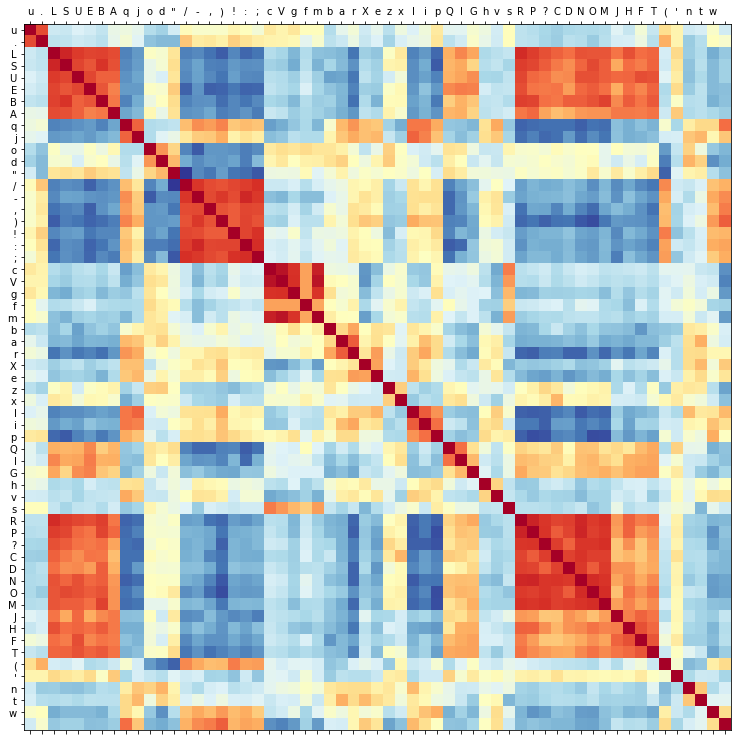

In [32]:
plotDistanceMatrixCluster(
    clfM2.coef_,
    clfM2.classes_,
    n_clusters=20)

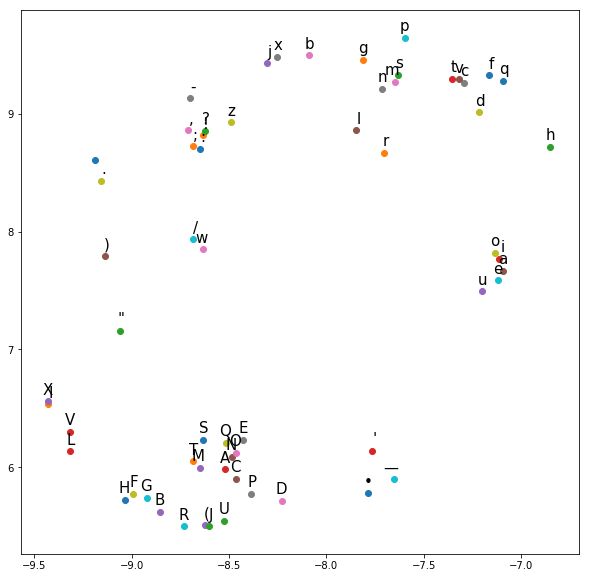

In [33]:
plotTSNE(clfM2.coef_,clfM2.classes_, metric='cosine')

<br/><br/><br/><br/><br/><br/><br/><br/>

# modelo 3 - Language Model Skip-gram

In [34]:
def lm3_transform(doc,vocab, ngramas, verbose=False):
    arr = [doc[i:i+2*ngramas+1] for i in range(len(doc)-(2*ngramas))];
    
    values = np.zeros((len(arr), len(vocab)));
    keys = [];
    
    for i,d in enumerate(arr):
        keys.append(d[ngramas]);
        if verbose: print (d, '==>',d[0:ngramas],'-', d[ngramas],'-',d[(ngramas+1):] )
        for j,vv in enumerate(d[0:(ngramas-1)]):
            values[i,vocab[vv]]+=(j+1.0)/ngramas; #crescent
        for j,vv in enumerate(d[(ngramas+1):]):
            values[i,vocab[vv]]+=(ngramas -j+1.0)/ngramas;            
            
    
    return values, keys;

In [35]:
x, y=lm3_transform('A word shall be defined', vocabulary,3,verbose=True);
for i,v in enumerate(x[0]):
    if v >0:
        print(invVocabulary[i],'=',v)

A word  ==> A w - o - rd 
 word s ==>  wo - r - d s
word sh ==> wor - d -  sh
ord sha ==> ord -   - sha
rd shal ==> rd  - s - hal
d shall ==> d s - h - all
 shall  ==>  sh - a - ll 
shall b ==> sha - l - l b
hall be ==> hal - l -  be
all be  ==> all -   - be 
ll be d ==> ll  - b - e d
l be de ==> l b - e -  de
 be def ==>  be -   - def
be defi ==> be  - d - efi
e defin ==> e d - e - fin
 define ==>  de - f - ine
defined ==> def - i - ned
  = 1.3333333333333333
A = 0.3333333333333333
d = 1.0
r = 1.3333333333333333


In [36]:
result = [];
for i in [1,2,3,5,7]:
    print('\nneighborhood:',i)
    acc=[];
    clf = LogisticRegression(random_state=42, C=10000,multi_class='multinomial',solver='lbfgs');
    for d in docs:
        X, Y = lm3_transform(d, vocabulary,i)
        X = normalize(X,axis=1, norm='l2');
        clf.fit(X,Y);
        accuracy =clf.score(X,Y);
        acc.append(accuracy);
    result.append({"i":i,'v0':acc[0],'v1':acc[1],'v2':acc[2], 'clf':clf})


neighborhood: 1

neighborhood: 2

neighborhood: 3

neighborhood: 5

neighborhood: 7


In [37]:
pd.DataFrame(result)#.plot(x='i', y=['v0','v1','v2'])

,clf,i,v0,v1,v2
0,"LogisticRegression(C=10000, class_weight=None,...",1,0.246774,0.275047,0.266817
1,"LogisticRegression(C=10000, class_weight=None,...",2,0.300771,0.320867,0.304887
2,"LogisticRegression(C=10000, class_weight=None,...",3,0.290691,0.302488,0.296014
3,"LogisticRegression(C=10000, class_weight=None,...",5,0.279623,0.299453,0.289411
4,"LogisticRegression(C=10000, class_weight=None,...",7,0.268269,0.291102,0.279539


In [38]:
clfM3 = LogisticRegression(random_state=42, C=10000,multi_class='multinomial',solver='lbfgs');
X, Y = lm3_transform(' '.join(docs), vocabulary,2)
X = normalize(X,axis=1, norm='l2');
clfM3.fit(X,Y);
accuracy =clfM3.score(X,Y);
print (accuracy)

0.30247234347213564


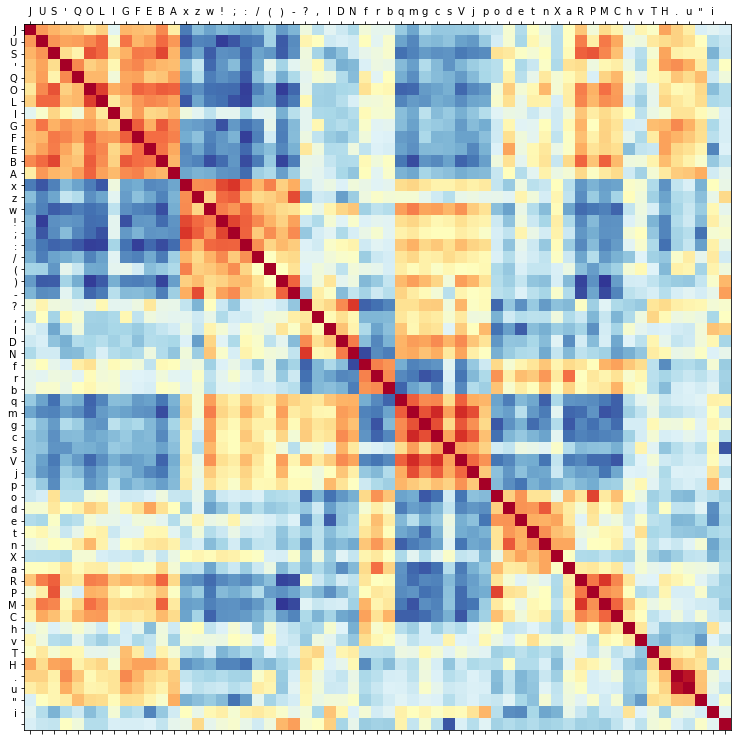

In [39]:
plotDistanceMatrixCluster(
    clfM3.coef_,
    clfM3.classes_,
    n_clusters=10)

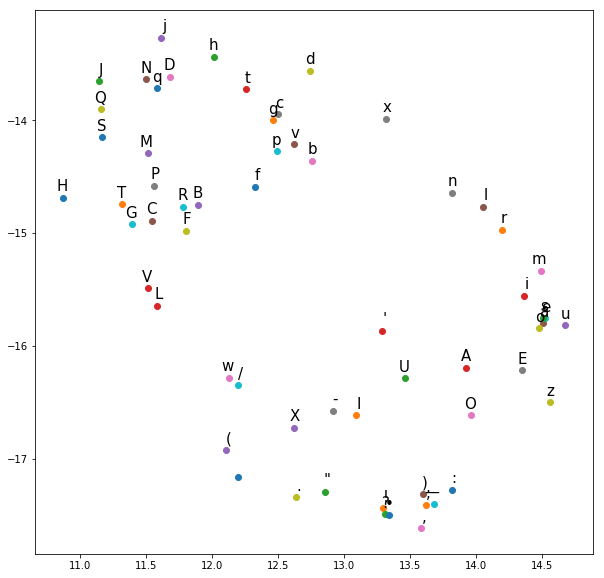

In [40]:
plotTSNE(clfM3.coef_,
    clfM3.classes_, metric='cosine')

<br/><br/><br/><br/><br/><br/><br/><br/>

# modelo 4 - Language Model Skip-gram - weight zipf

In [41]:
def lm4_transform(doc,vocab, ngramas, verbose=False):
    arr = [doc[i:i+2*ngramas+1] for i in range(len(doc)-(2*ngramas))];
    
    values = np.zeros((len(arr), len(vocab)));
    keys = [];
    
    for i,d in enumerate(arr):
        keys.append(d[ngramas]);
        if verbose: print (d, '==>',d[0:ngramas],'-', d[ngramas],'-',d[(ngramas+1):] )
        for j,vv in enumerate(d[0:ngramas]):
            values[i,vocab[vv]]+= vocabularyInvTF[vv]*(j+1.0)/ngramas; #crescent
        for j,vv in enumerate(d[(ngramas+1):]):
            values[i,vocab[vv]]+=vocabularyInvTF[vv]*(ngramas -j+1.0)/ngramas;            
    
    return values, keys;

In [42]:
x, y=lm4_transform('A word shall be defined', vocabulary,3,verbose=True);
for i,v in enumerate(x[0]):
    if v >0:
        print(invVocabulary[i],'=',v)

A word  ==> A w - o - rd 
 word s ==>  wo - r - d s
word sh ==> wor - d -  sh
ord sha ==> ord -   - sha
rd shal ==> rd  - s - hal
d shall ==> d s - h - all
 shall  ==>  sh - a - ll 
shall b ==> sha - l - l b
hall be ==> hal - l -  be
all be  ==> all -   - be 
ll be d ==> ll  - b - e d
l be de ==> l b - e -  de
 be def ==>  be -   - def
be defi ==> be  - d - efi
e defin ==> e d - e - fin
 define ==>  de - f - ine
defined ==> def - i - ned
  = 3.5874922167138883
A = 2.213526669101318
d = 4.354058200202225
r = 5.39005101908133
w = 10.577295625322472


In [43]:
result = [];
for i in [1,2,3,5,7]:
    print('\nneighborhood:',i)
    acc=[];
    clf = LogisticRegression(random_state=42, C=10000,multi_class='multinomial',solver='lbfgs');
    for d in docs:
        X, Y = lm4_transform(d, vocabulary,i)
        X = normalize(X,axis=1, norm='l2');
        clf.fit(X,Y);
        accuracy =clf.score(X,Y);
        acc.append(accuracy);
    result.append({"i":i,'v0':acc[0],'v1':acc[1],'v2':acc[2], 'clf':clf})


neighborhood: 1

neighborhood: 2

neighborhood: 3

neighborhood: 5

neighborhood: 7


In [44]:
pd.DataFrame(result)#.plot(x='i', y=['v0','v1','v2'])

,clf,i,v0,v1,v2
0,"LogisticRegression(C=10000, class_weight=None,...",1,0.306705,0.353497,0.343977
1,"LogisticRegression(C=10000, class_weight=None,...",2,0.346301,0.366570,0.355645
2,"LogisticRegression(C=10000, class_weight=None,...",3,0.346401,0.378468,0.363465
3,"LogisticRegression(C=10000, class_weight=None,...",5,0.343641,0.379605,0.358668
4,"LogisticRegression(C=10000, class_weight=None,...",7,0.332240,0.367788,0.347812


In [46]:
clfM4 = LogisticRegression(random_state=42, C=10000,multi_class='multinomial',solver='lbfgs');
X, Y = lm4_transform(' '.join(docs), vocabulary,3)
X = normalize(X,axis=1, norm='l2');
clfM4.fit(X,Y);
accuracy =clfM4.score(X,Y);
print (accuracy)

0.3481009734748317


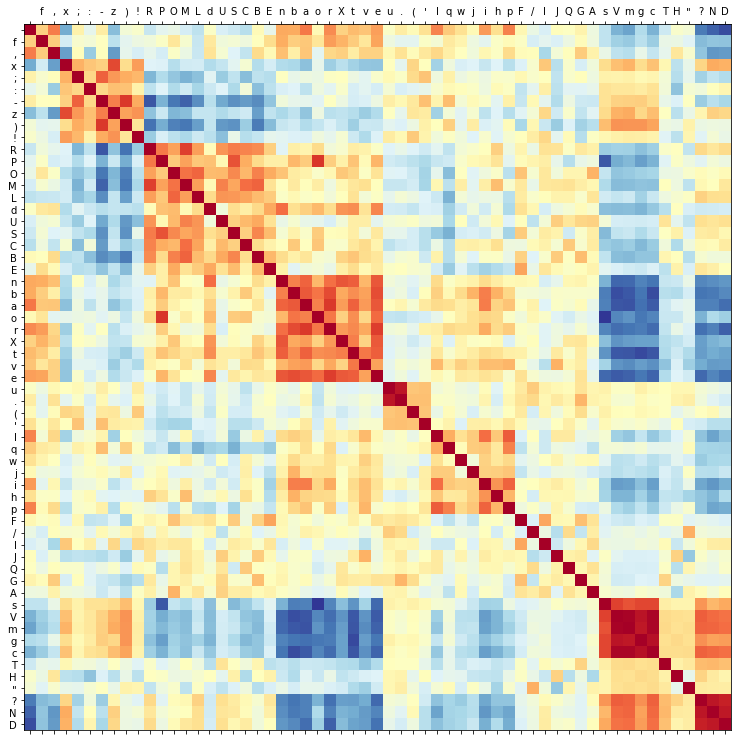

In [47]:
plotDistanceMatrixCluster(
    clfM4.coef_,
    clfM4.classes_,
    n_clusters=10)

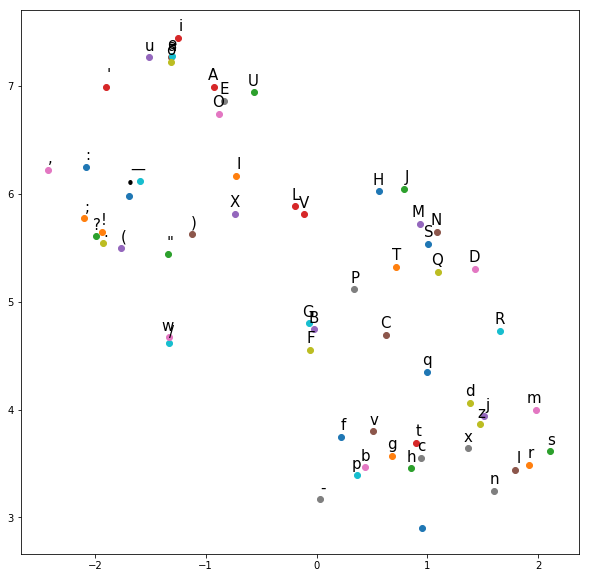

In [48]:
plotTSNE(clfM4.coef_,clfM4.classes_, metric='cosine')

### lowercase

In [51]:
clfM41 = LogisticRegression(random_state=42, C=10000,multi_class='multinomial',solver='lbfgs');
X, Y = lm4_transform(' '.join(docs).lower(), vocabulary,3)
X = normalize(X,axis=1, norm='l2');
clfM41.fit(X,Y);
accuracy =clfM41.score(X,Y);
print (accuracy)

0.34454426827719203


In [52]:
pd.DataFrame(result)#.plot(x='i', y=['v0','v1','v2'])

,clf,i,v0,v1,v2
0,"LogisticRegression(C=10000, class_weight=None,...",1,0.306705,0.353497,0.343977
1,"LogisticRegression(C=10000, class_weight=None,...",2,0.346301,0.366570,0.355645
2,"LogisticRegression(C=10000, class_weight=None,...",3,0.346401,0.378468,0.363465
3,"LogisticRegression(C=10000, class_weight=None,...",5,0.343641,0.379605,0.358668
4,"LogisticRegression(C=10000, class_weight=None,...",7,0.332240,0.367788,0.347812


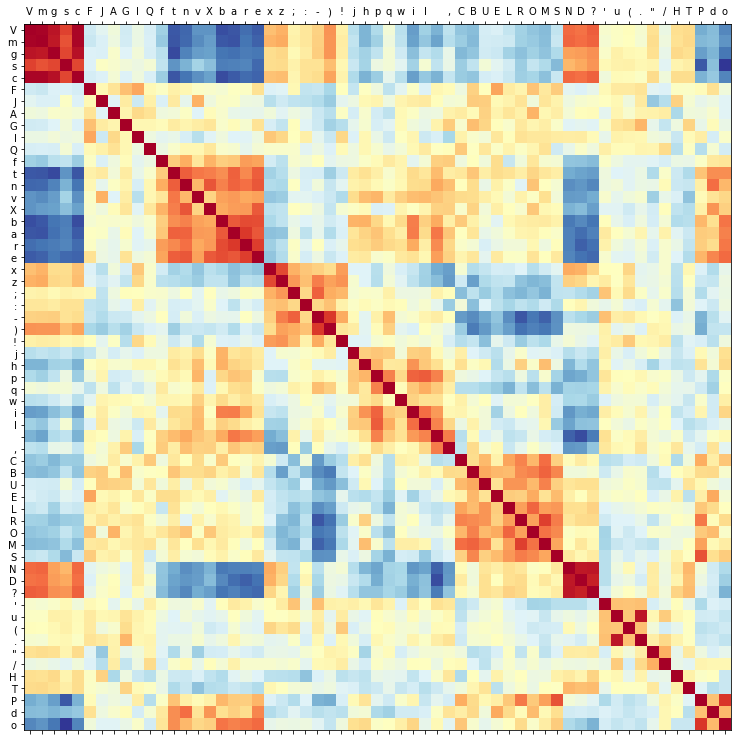

In [53]:
plotDistanceMatrixCluster(
    clfM4.coef_,
    clfM4.classes_,
    n_clusters=10)

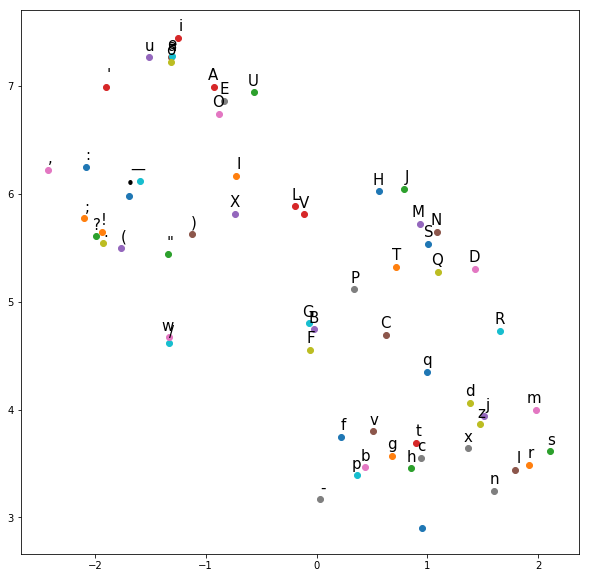

In [54]:
plotTSNE(clfM4.coef_,clfM4.classes_, metric='cosine')